# **CS473 - Assignment 4**

In [1]:
import copy
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm.notebook import trange

In [2]:
data = pd.read_csv('dataset.csv')
id = data['id'].values
labels = data['labels'].values
x = data[['feature_0', 'feature_1']].values.T

## **Question 1**

#### 1.

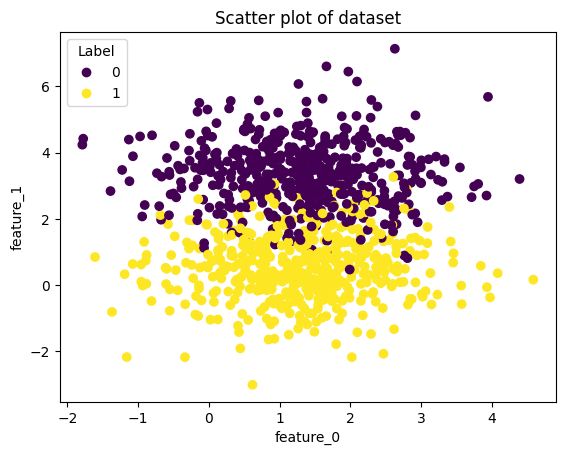

In [3]:
scatter = plt.scatter(x[0], x[1], c=labels)
plt.legend(*scatter.legend_elements(), loc="upper left", title="Label")
plt.xlabel('feature_0')
plt.ylabel('feature_1')
plt.title('Scatter plot of dataset')
plt.show()

We can see that samples from different classes overlap, so there is no possible straight line that can separate them. So the dataset is not linearly separable.

#### 2. <br>

In [4]:
def accuracy(pred, labels):
    return np.sum(pred == labels) / len(labels)

class Scheduler:
    pass

In [5]:
def train_single_sample(a, y, labels, n_iters, lr, variable_lr=False):
    acc_hist = []
    w = copy.deepcopy(a)
    best_acc = -1
    if variable_lr:
        scheduler = Scheduler(y.shape[1], lr)

    loop = trange(n_iters)

    for i in loop:
        if variable_lr:
            lr = scheduler.get_next_lr()

        k = np.random.randint(len(y))

        y_k = y[:, k]
        pred_k = (a.T @ y_k > 0).astype(int)

        a = a + lr * y_k * (labels[k] - pred_k)

        if i % y.shape[1] == 0:
            pred = (a.T @ y > 0).astype(int)
            acc = accuracy(pred, labels)

            if acc > best_acc:
                w = copy.deepcopy(a)
                best_acc = acc

            acc_hist.append(acc)
            loop.set_description(f"Iteration {i}")
            loop.set_postfix(accuracy=acc)

    loop.close()

    return w, acc_hist

#### 3.

In [6]:
def plot_model(w, data, lalels):
    xlim = (np.min(data[0])-1, np.max(data[0])+1)
    ylim = (np.min(data[1])-1, np.max(data[1])+1)
    sample_rate = 100

    x = np.linspace(xlim[0], xlim[1], sample_rate)
    y = np.linspace(ylim[0], ylim[1], sample_rate)
    xx, yy = np.meshgrid(x, y)
    Xgrid = np.vstack([xx.ravel(), yy.ravel()])
    Xgrid = np.concatenate((Xgrid, np.ones((1, Xgrid.shape[1]))), axis=0)

    z = (w.T @ Xgrid >= 0).astype(int).reshape(xx.shape)
    plt.contourf(x, y, z, alpha=0.3)

    scatter = plt.scatter(data[0], data[1], c=labels)
    plt.legend(*scatter.legend_elements(), loc="upper left", title="label")

    plt.xlabel('feature_1')
    plt.ylabel('feature_2')
    plt.show()

#### 4.

In [7]:
n_iters = 100000
lr = 1

a = np.random.rand(x.shape[0] + 1)
y = np.concatenate((x, np.ones((1, x.shape[1]))), axis=0)

w, acc_hist = train_single_sample(a, y, labels, n_iters, lr, False)

  0%|          | 0/100000 [00:00<?, ?it/s]

#### 5.

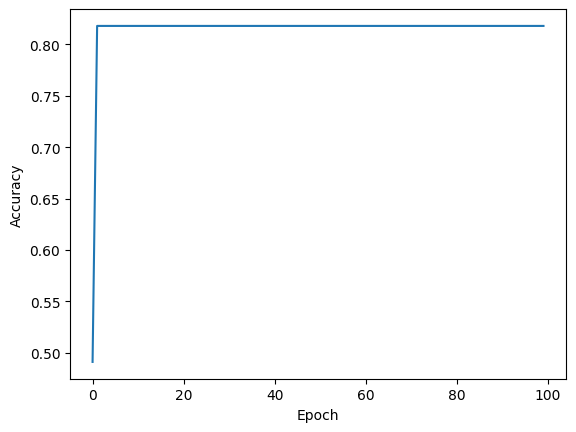

In [8]:
def plot_acc(acc_hist):
    plt.plot(acc_hist)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()

plot_acc(acc_hist)

#### 6.

accuracy: 0.818


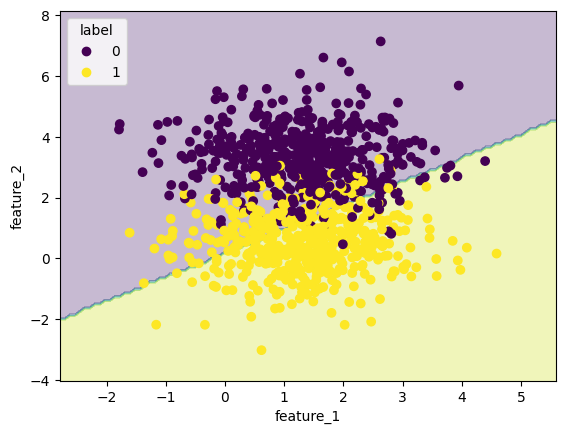

In [9]:
print(f"accuracy: {accuracy((w.T @ y > 0).astype(int), labels)}")
plot_model(w, x, labels)

#### 7.

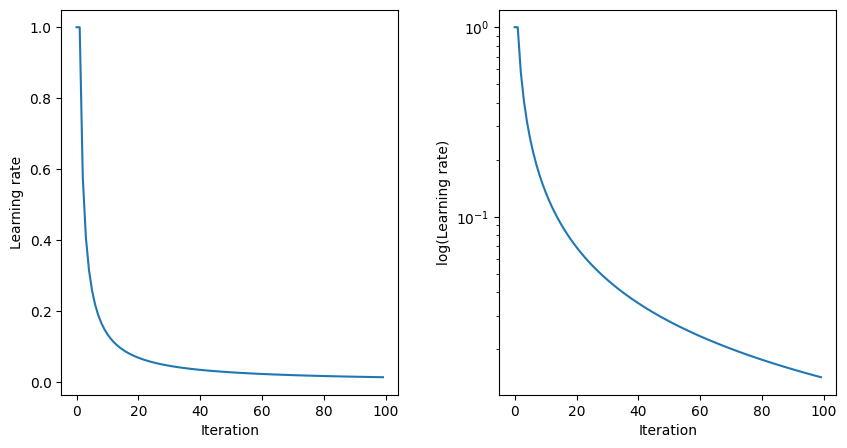

In [10]:
class Scheduler:
    def __init__(self, n, lr=0.1, patience=0):
        self.n = n
        self.lr = lr
        self.patience = patience
        self.i = -1
        self.k = 0

    def get_next_lr(self):
        self.i += 1
        if self.i == 0:
            return self.lr
        self.k += (self.i % self.n)

        if self.i > self.patience:
            self.lr = 1/np.sqrt(self.k)

        return self.lr

lr = 1
scheduler = Scheduler(x.shape[1], lr)
lrs = [scheduler.get_next_lr() for _ in range(100)]

fig, axs = plt.subplots(1, 2, figsize=(10,5))
plt.subplots_adjust(wspace=0.3)
axs[0].plot(lrs)
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Learning rate')
axs[1].plot(lrs)
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('log(Learning rate)')
axs[1].set_yscale('log')
plt.show()

#### 8.

  0%|          | 0/100000 [00:00<?, ?it/s]

accuracy: 0.808


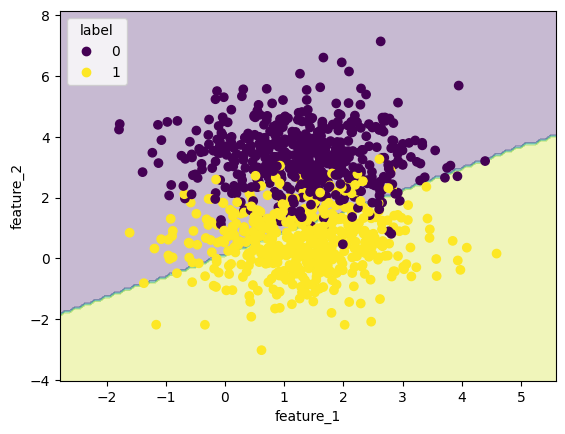

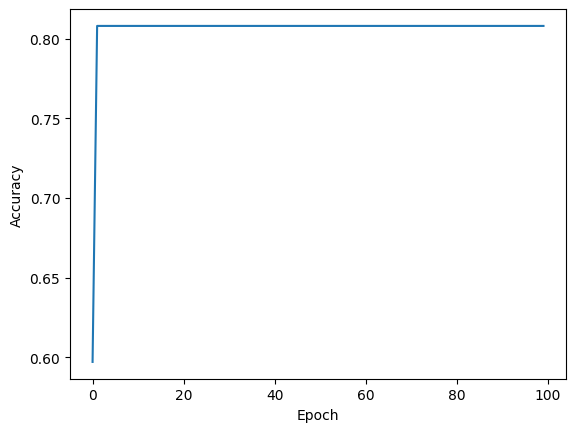

In [11]:
n_iters = 100000
lr = 1

w, acc_hist = train_single_sample(a, y, labels, n_iters, lr, True)

print(f"accuracy: {accuracy((w.T @ y > 0).astype(int), labels)}")
plot_model(w, x, labels)
plot_acc(acc_hist)

Training is not deterministic because of the randomness in the initial weights and sample selection, however generally we can see that using a variable learning rate will yield slightly lower accuracy than using a constant one, and both will not have great results. <br>
This is because by using a single sample, the gradient will be "noisy" and it will be very likely that it will not be the best direction to move towards in the long run. With a "large" constant learning rate, we will be able to escape any local minima that result from this, however it will be hard to reach a very good minimum. With a variable learning rate, we probably won't be able to escape in this case, however in the rarer case that the gradients are "favorable" we will be able to reach a better minimum than with the constant learning rate. <br>
Because of the respective disadvantages, we can see that we can't impove accuracy past a point that we reach early into training, so it is unlikely that we can achieve great results using a single sample.

## **Question 2**

#### 1.

In [35]:
def train_batch(a, y, labels, n_iters, theta, batch_size, lr=1, variable_lr=False):
    acc_hist = []
    error_hist = []
    w = copy.deepcopy(a)
    best_acc = -1
    if variable_lr:
        scheduler = Scheduler(y.shape[1], lr)

    loop = trange(n_iters)

    for i in loop:
        if variable_lr:
            lr = scheduler.get_next_lr()

        idx = np.random.choice(y.shape[1], batch_size, replace=False)
        batch = y[:, idx]
        batch_labels = labels[idx]
        pred = (a.T @ batch > 0).astype(int)
        diff = batch_labels - pred

        error = (batch * diff).sum(axis=1)
        a = a + lr * error

        if i % (y.shape[1] // batch_size) == 0:
            pred = ((a.T @ y) >= 0).astype(int)
            acc = accuracy(pred, labels)
            if acc > best_acc:
                w = copy.deepcopy(a)
            best_acc = acc

            error = np.absolute(error).sum()
            error_hist.append(error)
            acc_hist.append(acc)
            loop.set_description(f"Iteration {i}")
            loop.set_postfix(accuracy=acc, error=error)

            if lr * error < theta:
                break

    loop.close()

    return w, acc_hist, error_hist

#### 2.

In [56]:
n_iters = 100000
lr = 1
theta = 0.01
batch_size = 16

a = np.random.rand(x.shape[0] + 1)

w, acc_hist, error_hist = train_batch(a, y, labels, n_iters, theta, batch_size, lr, False)

  0%|          | 0/100000 [00:00<?, ?it/s]

#### 3.

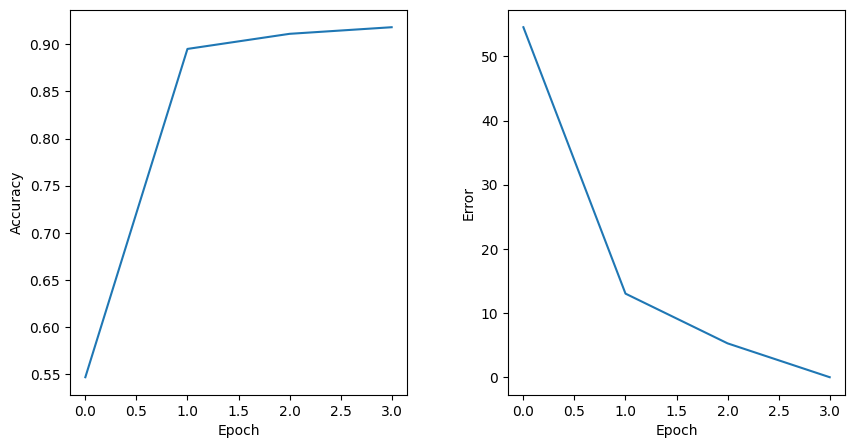

In [57]:
def plot_acc_error(acc_hist, error_hist):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    plt.subplots_adjust(wspace=0.3)

    axs[0].plot(acc_hist)
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Accuracy')

    axs[1].plot(error_hist)
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Error')

plot_acc_error(acc_hist, error_hist)

#### 4.

accuracy: 0.918


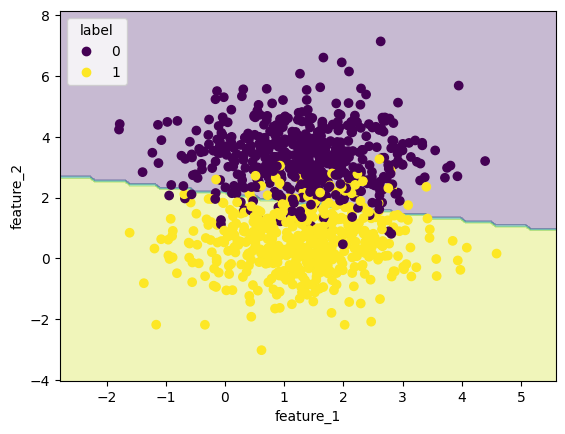

In [58]:
print(f"accuracy: {accuracy((w.T @ y > 0).astype(int), labels)}")
plot_model(w, x, labels)

#### 5.

  0%|          | 0/100000 [00:00<?, ?it/s]

accuracy: 0.912


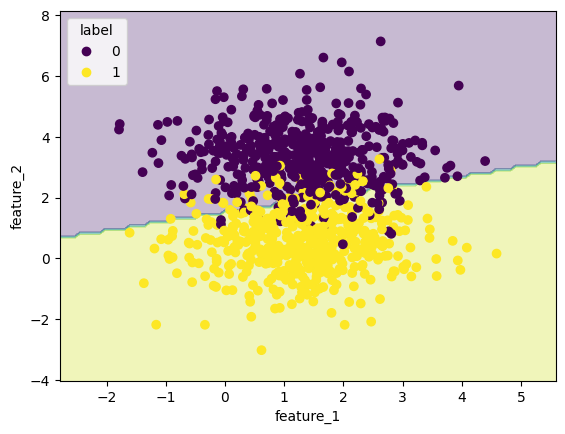

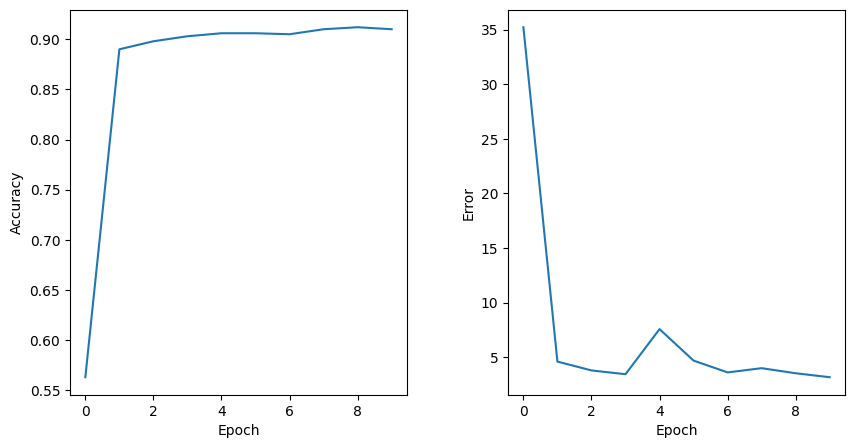

In [59]:
w, acc_hist, error_hist = train_batch(a, y, labels, n_iters, theta, batch_size, lr, True)

print(f"accuracy: {accuracy((w.T @ y > 0).astype(int), labels)}")
plot_model(w, x, labels)
plot_acc_error(acc_hist, error_hist)

We can see that whether we use a constant or variable learning rate, the results are usually close but tend to be better with a variable learning rate, and are both quite better than the single sample perceptron. <br>
The significant factor, that is different in this case compared to the single sample perceptron, is that by using a batch the gradient will be more accurate. This means that we can take advantage of the variable learning rate, since it will be less likely to reach a "bad" minumum that we can't escape because of the smaller learning rate, but also we can reach closer to a good minimum because of the small learning rate. On the other hand, a constantly "high" learning rate will not usually be needed since we're unlikely to need to escape "bad" minima, and prevents us from reaching very close to a "good" minimum. <br>
In the rare case that a "bad" gradient occurs, then the constant learning rate will probably do better, since it will then be able to escape the local minimum to reach a better one. However results can vary due to randomness.